In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [3]:
β1 = 0.015
β2 = 0.008
β3 = 0.006 
    

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
    ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
    waist = [Normal(2.9, 0.03)],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)],
    psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
    cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), 
    cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), 
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
);

labels = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [4]:
include("../likelihood.jl")
include("../utill.jl")

corner_plots (generic function with 1 method)

In [5]:
FPATH = "../../data/sampling_results/LongRun/"
eventp = "hc-113.hdf5"
event_number = 113

113

In [6]:
outp_tmp = bat_read(FPATH*eventp) 
smpl_2_3 = varshape(prior).(outp_tmp)
smpl_flat_2_3 = bat_sample(smpl_2_3, length(smpl_2_3)).result
smpl_flat_2_3 = flatview(unshaped.(smpl_flat_2_3.v));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm OrderedResampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [7]:
conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../../data/experiment/dataset_2/m2/images-satur.jld2");

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


In [8]:
images = load("../../data/experiment/dataset_2/m2/images.jld2");

event_nt = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

In [9]:
function eval_conv(conv_matrix, ind)
    ind = convert.(Int64, ind)
    y_tmp = exp.(conv_matrix[:, ind[1]+1])
    for ind_tmp in ind[2:end]
        y_tmp = conv(y_tmp, exp.(conv_matrix[:, ind_tmp+1]))
    end
    
    prepend!(y_tmp, repeat([0], length(ind)-1))
    
    y_tmp = y_tmp .- minimum(y_tmp)
    y_tmp = y_tmp ./ sum(y_tmp)
end

function eval_conv_is(ind)
    
    mue = sum(ind)
    
    sigma = sqrt(sum((2.0 .* sqrt.(ind)).^2))

    return truncated(Normal(mue, sigma), 0, Inf)
end

eval_conv_is (generic function with 1 method)

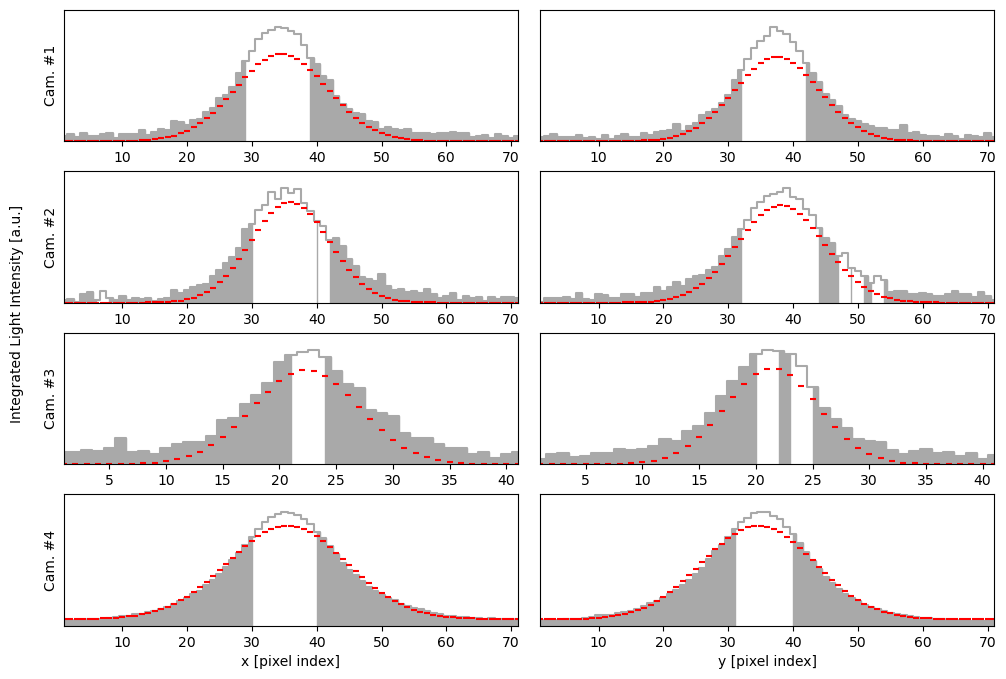

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [10]:
amp_coeff = 1.15

median_params = median(smpl_2_3)[1]
median_event = generate_event(median_params, 
    event_nt.population, conv_matrices; 
    inc_noise=false, 
    size=[size(event_nt.cam_1), size(event_nt.cam_2), size(event_nt.cam_3), size(event_nt.cam_4)], 
    include_satur=false)


fig, ax = plt.subplots(4,2, figsize=(12,8))
fig.subplots_adjust(hspace=0.23, wspace=0.05)


for i in 1:4 
    ycounts_nt = [sum(event_nt[i], dims=1)...]
    ycounts_tr = [sum(event[i], dims=1)...]
    median_sum = [sum(median_event[i], dims=1)...]
    
#     fluct = [[sum(j[i], dims=1)...] for j in multiple_events]
#     fluct = hcat(fluct...)
#     fluct_up = [quantile(a, FrequencyWeights(weights_tmp), 0.999, ) for a in eachrow(fluct)] .- median_sum
#     fluct_down = median_sum .- [quantile(a, 0.001) for a in eachrow(fluct)] 
    
    xedges = 1:length(ycounts_tr)

    ax[i,1].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
    ax[i,1].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
    
    ax[i,1].scatter(xedges, median_sum, marker = "_", color="red", s=20)
#     ax[i,1].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], fmt="_", color="red", ecolor="red",  capthick=1, capsize=0, linewidth=1)
    
    ax[i,1].set_ylim(0, amp_coeff*maximum(ycounts_nt))
    ax[i,1].set_xlim(minimum(xedges), maximum(xedges))
    
    ycounts_nt = [sum(event_nt[i], dims=2)...]
    ycounts_tr = [sum(event[i], dims=2)...]
    median_sum = [sum(median_event[i], dims=2)...]
    
#     fluct = [[sum(j[i], dims=2)...] for j in multiple_events]
#     fluct = hcat(fluct...)
#     fluct_up = [quantile(a, FrequencyWeights(weights_tmp), 0.999, ) for a in eachrow(fluct)] .- median_sum
#     fluct_down = median_sum .- [quantile(a, 0.001) for a in eachrow(fluct)] 
    
    xedges = 1:length(ycounts_tr)

    ax[i,2].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
    ax[i,2].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
    
    ax[i,2].scatter(xedges, median_sum, marker = "_", color="red", s=20)
#     ax[i,2].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], fmt="_", color="red", ecolor="red",  capthick=1, capsize=0, linewidth=1)
    
    ax[i,2].set_ylim(0, amp_coeff*maximum(ycounts_nt))
    ax[i,2].set_xlim(minimum(xedges), maximum(xedges))
    
    ax[i,1].set_yticks([])
    ax[i,2].set_yticks([])
end

ax[4,1].set_xlabel("x [pixel index]")
ax[4,2].set_xlabel("y [pixel index]")

ax[1,1].set_ylabel("Cam. #1")
ax[2,1].set_ylabel("Cam. #2")
ax[3,1].set_ylabel("Cam. #3")
ax[4,1].set_ylabel("Cam. #4")

fig.text(0.08, 0.5, "Integrated Light Intensity [a.u.]", va="center", rotation="vertical")

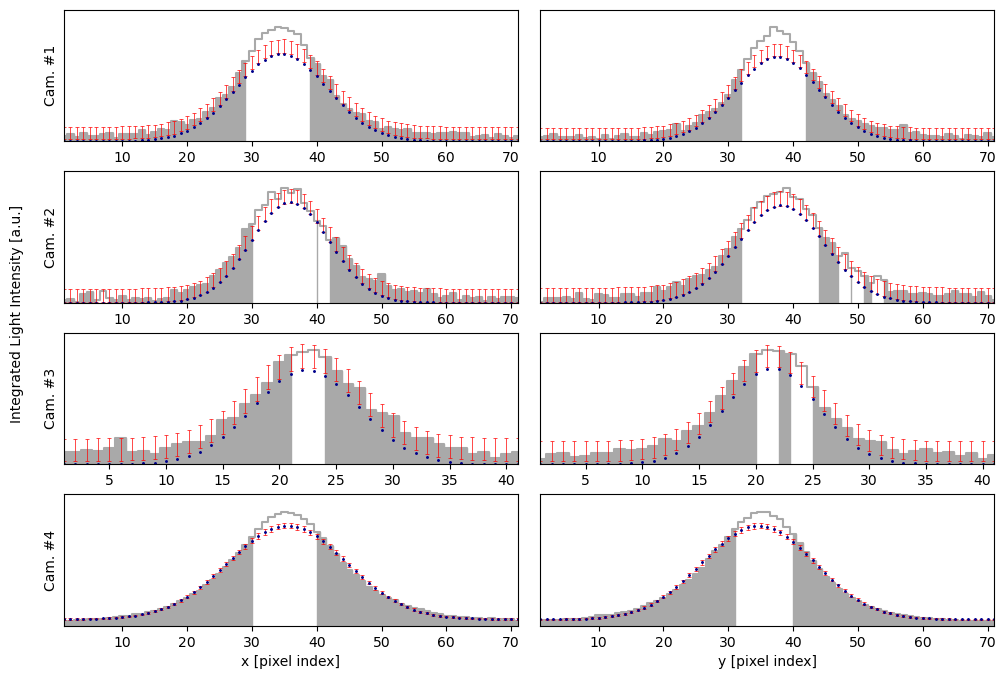

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [11]:
amp_coeff = 1.15
alpha_1 = 0.005
alpha_2 = 0.995

median_params = median(smpl_2_3)[1]
median_event = generate_event(median_params, 
    event_nt.population, conv_matrices; 
    inc_noise=false, 
    size=[size(event_nt.cam_1), size(event_nt.cam_2), size(event_nt.cam_3), size(event_nt.cam_4)], 
    include_satur=false)


fig, ax = plt.subplots(4,2, figsize=(12,8))
fig.subplots_adjust(hspace=0.23, wspace=0.05)


for i in 1:4 
    ycounts_nt = [sum(event_nt[i], dims=1)...]
    ycounts_tr = [sum(event[i], dims=1)...]
    median_sum = [sum(median_event[i], dims=1)...]
    
    xedges = 1:length(ycounts_tr)

    ax[i,1].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
    ax[i,1].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
    
    if i != 4
        fluct = [eval_conv(conv_matrices[i], j) for j in eachcol(median_event[i]) ]
        fluct_up = [argmin(abs.(cumsum(j) .- alpha_2)) for j in fluct] .- median_sum
        fluct_down = median_sum .- [argmin(abs.(cumsum(j) .- alpha_1)) for j in fluct] 
    else
        fluct = [eval_conv_is(j) for j in eachcol(median_event[i]) ]
        fluct_up = [quantile(j, alpha_2) for j in fluct] .- median_sum
        fluct_down = median_sum .- [quantile(j, alpha_1) for j in fluct]
    end
    
    ax[i,1].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)
    
    ax[i,1].set_ylim(0, amp_coeff*maximum(ycounts_nt))
    ax[i,1].set_xlim(minimum(xedges), maximum(xedges))
    
    ycounts_nt = [sum(event_nt[i], dims=2)...]
    ycounts_tr = [sum(event[i], dims=2)...]
    median_sum = [sum(median_event[i], dims=2)...]
    
    xedges = 1:length(ycounts_tr)

    ax[i,2].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
    ax[i,2].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
    
    if i != 4
        fluct = [eval_conv(conv_matrices[i], j) for j in eachrow(median_event[i]) ]
        fluct_up = [argmin(abs.(cumsum(j) .- alpha_2)) for j in fluct] .- median_sum
        fluct_down = median_sum .- [argmin(abs.(cumsum(j) .- alpha_1)) for j in fluct] 
    else
        fluct = [eval_conv_is(j) for j in eachrow(median_event[i]) ]
        fluct_up = [quantile(j, alpha_2) for j in fluct] .- median_sum
        fluct_down = median_sum .- [quantile(j, alpha_1) for j in fluct]
    end
    
    ax[i,2].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)
    
    ax[i,2].set_ylim(0, amp_coeff*maximum(ycounts_nt))
    ax[i,2].set_xlim(minimum(xedges), maximum(xedges))
    
    ax[i,1].set_yticks([])
    ax[i,2].set_yticks([])
end

ax[4,1].set_xlabel("x [pixel index]")
ax[4,2].set_xlabel("y [pixel index]")

ax[1,1].set_ylabel("Cam. #1")
ax[2,1].set_ylabel("Cam. #2")
ax[3,1].set_ylabel("Cam. #3")
ax[4,1].set_ylabel("Cam. #4")

fig.text(0.08, 0.5, "Integrated Light Intensity [a.u.]", va="center", rotation="vertical")